## 금융 사기 감지 모델

In [1]:
# 기본 데이터 처리 라이브러리
import pandas as pd # 테이블 형태 데이터(dataframe) 처리
import numpy as np # 수치 연산 라이브러리

# 데이터분석 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True) # 주피터에서 ploty 그래프 표시 가능하게 설정

# 데이터 전처리 라이브러리
from sklearn.preprocessing import StandardScaler # 데이터 표준화 : 피처를 0, 표준편차를 1로 스케일링
from sklearn.model_selection import train_test_split # 데이터 분할 : 훈련 데이터와 테스트 데이터 분할
from sklearn.preprocessing import LabelEncoder # 레이블 인코딩 : 범주형 데이터를 수치형 데이터로 변환


# 머신러닝 라이브러리
import tensorflow as tf # 딥러닝 모델 구축, 학습 프레임워크
from sklearn.svm import SVC # 서포트 벡터 머신 모델
from sklearn.svm import LinearSVC # 선형 서포트 벡터 머신 분류기
from sklearn.ensemble import ExtraTreesClassifier # 추가 트리 분류기 : 랜덤 포레스트 변형(더 랜덤한 분할)
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트 분류기 
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 분류기
from sklearn.tree import DecisionTreeClassifier # 결정 트리 분류기
from sklearn.naive_bayes import GaussianNB # 나이브 베이즈 분류기
from sklearn.neighbors import KNeighborsClassifier # K-최근접 이웃 분류기
from sklearn.pipeline import make_pipeline # 파이프라인 : 데이터 전처리와 모델 학습을 파이프라인으로 묶음
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV # 그리드 서치 : 하이퍼파라미터 튜닝(교차검증 기반)

#M 모델 평가 라이브러리
from sklearn import metrics # 다양한 평가 지표 모음
from sklearn.metrics import classification_report # 분류 모델 평가 지표(정확도, 정밀도, 재현율, F1-score)
from sklearn.model_selection import cross_val_score # 교차 검증 평가 지표(평균 정확도)
from sklearn.metrics import accuracy_score # 정확도 평가 지표
from sklearn.metrics import confusion_matrix # 혼동 행렬 평가 지표(TP, FP, TN, FN)



#기타 라이브러리
import warnings
warnings.filterwarnings("ignore") # 경고 메시지 제어

## Data 로드

In [2]:
# 데이터 읽기
paysim = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')

paysim.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
paysim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### 데이터 개요
행 : 6,362,620개 -> 각 행이 개별 금융 거래를 의미
이 데이터는 모바일 금융 거래 시뮬레이션(PaySim) 결과로, 
총 30일(744시간) 동안의 거래 기록을 포함한다.  
각 행은 한 건의 거래를 나타내며, 총 6,362,620개다.
주요 컬럼은 다음과 같다.

| 컬럼명 | 설명 |
|--------|------|
| **step** | 실제 세계의 시간 단위를 매핑한 값. 1 step = 1시간. 전체 step은 744(30일 시뮬레이션). |
| **type** | 거래 유형: `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`. |
| **amount** | 거래 금액(현지 통화 기준). |
| **nameOrig** | 거래를 시작한 고객 ID. |
| **oldbalanceOrg** | 거래 전 송금자의 계좌 잔액. |
| **newbalanceOrig** | 거래 후 송금자의 계좌 잔액. |
| **nameDest** | 거래 수취인 고객 ID. |
| **oldbalanceDest** | 거래 전 수취인의 계좌 잔액. **참고:** ID가 `M`(Merchants)로 시작하는 경우 정보 없음. |
| **newbalanceDest** | 거래 후 수취인의 계좌 잔액. **참고:** ID가 `M`(Merchants)로 시작하는 경우 정보 없음. |
| **isFraud** | 시뮬레이션 내에서 사기 행위자가 수행한 거래 여부. 사기 행위자는 고객 계정을 탈취해 자금을 다른 계좌로 이체한 뒤, 현금화(CASH-OUT)하는 것을 목표로 함. |
| **isFlaggedFraud** | 시스템이 불법 거래 시도로 플래그한 여부. 이 데이터셋에서 불법 거래 시도는 **단일 거래에서 200,000 초과 금액**을 이체하려는 경우로 정의됨. |


### 피봇 테이블 분석

피봇 테이블은 원본 데이터 변형 없이 요약, 집계 가능

In [4]:
#Pivot table
paysim_pivot1=pd.pivot_table(
    paysim,
    index=["type"],
    values=['amount','isFraud','isFlaggedFraud'],
    aggfunc=[np.sum,np.std], 
    margins=True)

#Adding color gradient 
cm = sns.light_palette("green", as_cmap=True)
paysim_pivot1.style.background_gradient(cmap=cm)

In [5]:

# 현재 규칙 기반 알고리즘에 따르면, 현금 인출 시 사기 거래에 대한 플래그 전혀 발생하지 않음
# transaction시에도 실제 사기 거래는 4천건이지만 16건 밖에 감지 못 함

In [6]:
#Pivot table
paysim_pivot2=pd.pivot_table(
    paysim,
    index=["type"],
    values=['amount','oldbalanceOrg','newbalanceOrig'], # 송금자 관련 금액
    aggfunc=np.sum, # 집계함수    
    margins=True) # 맨 아래 'all' 행과 열 추가  

#Adding style
(
    paysim_pivot2.style
        .format('{:.2f}')
        .bar(color='darkred')
        .set_properties(padding='5px',border='3px solid white',width='200px')
)

,amount,newbalanceOrig,oldbalanceOrg
type,,,
CASH_IN,236367391912.46,5260438481752.39,5024078139747.24
CASH_OUT,394412995224.49,39098506249.34,102978263227.81
DEBIT,227199221.28,2699777564.12,2844196471.80
PAYMENT,28093371138.37,133043913105.10,146768163438.80
TRANSFER,485291987263.17,5482651300.55,29012552760.76
All,1144392944759.77,5440763329971.49,5305681315646.41


In [7]:
# 데이터의 거래 유형은 transfer이 많음 payment는 적음
# old -> new 가 입금 거래를 제외한 모든 경우에서 줄어듦
# 송금 거래에서도 잔액이 줄어드는 걸 보면, 데이터가 주로 송금 쪽 중심임.

In [8]:
#Pivot table
paysim_pivot3=pd.pivot_table(
    paysim,
    index=["type"],
    values=['amount','oldbalanceDest','newbalanceDest'], # 수취인 관련 금액
    aggfunc=[np.sum], 
    margins=True)

#Adding style
paysim_pivot3.style\
    .format('{:.2f}')\
    .bar(color='darkblue')\
    .set_properties(padding='5px',border='3px solid white',width='200px')

In [9]:
# 돈을 받는 사람의 정보
# PAYMENT(결제) 거래에서 수취인은 보통 상점(M으로 시작하는 merchant 계정)
# -> PaySim 원본 설명에 따르면 이들의 잔액 정보는 제공되지 않음
# 그래서 destination 쪽 테이블에 PAYMENT 금액/잔액 정보가 비어 있거나 NaN으로 나오는 것

### 데이터 약간 줄이기

상위 50k개의 행으로 좀 줄이기 + 거래 금액 분포 파악

In [11]:
#Reading the first 50000 rows
paysim=pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv',nrows=50000)

#Distribution of Amount
fig = px.box(paysim, y="amount")
fig.show()

In [12]:
# 대부분의 거래는 소액이지만, 소수의 고액 거래가 멀리 퍼져있음 (이상치)
# min (최소값): 0.63
# Q1 (1사분위수): 약 7,734원 — 전체 거래 중 25%는 이 금액 이하
# median (중앙값): 약 33,415원 — 절반의 거래가 이 금액 이하
# Q3 (3사분위수): 약 187,840원 — 75%의 거래가 이 금액 이하
# upper fence (상한 경계): 약 457,827원 — 이를 넘으면 이상치로 간주
# max (최대값): 1천만 원 — 극단적으로 큰 거래 금액


## Feature engineering¶

현재 사용 가능한 정보로는 모델을 학습시키기 어려우므로
기존 피처를 수정해서 도메인 특화 새로운 피처 4개를 생성할거임
여기서는 해당 도메인과 매우 관련성이 높은 피처를 생성하는 세가 가지 함수 생성함

- Difference in balance(잔액차이) : 정상적인 금융 거래라면 송신자 계좌에서 빠진 금액과 수신자 계좌에 들어온 금액이 정확히 일치해야 함(수수료 같은 예외가 있을 수 있지만 어찌됐건 표시해야 함).
- Surge indicator(고액 거래 플래그) : EDA 에서 본 것처럼 거래 금액 분포에 고액 이상치 존재. 상치가 존재. 75퍼센타일(≈ 450,000)을 임계값으로 설정, 이 금액을 초과하는 거래는 flag 처리
- Frequency indicator (수신 빈도 플래그) :
여기서는 거래가 아니라 사용자를 표시함. 특정 수신자가 많은 사람들로부터 반복적으로 돈을 받는 경우 → 불법 도박, 사기 가능성. 
임계값: 동일 수신자가 20회 이상 돈을 받으면 flag
- Merchant indicator (상점 계정 플래그) :
수신자 ID가 M으로 시작하면 merchant(상점) 계정
상점 계정은 원래 수신 거래가 많지만, 이번 분석에서는 merchant인 경우 flag로 표시해 모델이 참고하도록 함


In [13]:
# balance_diff(data) — 잔액 차이 플래그 생성
def balance_diff(data):
    '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
       then it creates a new column which indicates 1 when there is a deviation else 0'''
    
    # 송신자의 잔액 변동
    orig_change=data['newbalanceOrig']-data['oldbalanceOrg']
    orig_change=orig_change.astype(int)
    for i in orig_change:
        if i<0: # 음수면 돈 빠져나간 것, 양수면 들어온 것
            data['orig_txn_diff']=round(data['amount']+orig_change,2)
        else:
            data['orig_txn_diff']=round(data['amount']-orig_change,2)

    # 거래 금액과 잔액 변화의 차이 계산 (0 아니면 불일치)
    data['orig_txn_diff']=data['orig_txn_diff'].astype(int)
    # orig_diff 컬럼에 1(불일치) 또는 0(정상) 할당
    data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']] 
    
    # 수신자의 잔액 변동
    dest_change=data['newbalanceDest']-data['oldbalanceDest']
    dest_change=dest_change.astype(int)
    for i in dest_change:
        if i<0:
            data['dest_txn_diff']=round(data['amount']+dest_change,2)
        else:
            data['dest_txn_diff']=round(data['amount']-dest_change,2)

    # 거래 금액과 잔액 변화의 차이 계산 (0 아니면 불일치)
    data['dest_txn_diff']=data['dest_txn_diff'].astype(int)
    # dest_diff 컬럼에 1(불일치) 또는 0(정상) 할당
    data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']] 
    
    # orig_txn_diff, dest_txn_diff 컬럼 삭제
    data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)

    # orig_diff, dest_diff 컬럼 두 개 만들어짐


In [14]:

#Surge indicator - 고액 거래 플래그 생성
def surge_indicator(data):
    '''Creates a new column which has 1 if the transaction amount is greater than the threshold
    else it will be 0'''
    # 거래 금액이 450,000원 이상이면 1, 아니면 0
    data['surge']=[1 if n>450000 else 0 for n in data['amount']]

#Frequency indicator - 다수 송신자 수신 플래그 생성
def frequency_receiver(data):
    '''Creates a new column which has 1 if the receiver receives money from many individuals
    else it will be 0'''
    # 각 수신자가 몇 번 돈을 받았는지 계산
    data['freq_Dest']=data['nameDest'].map(data['nameDest'].value_counts())
    # 수신자가 20번 이상 돈을 받으면 1, 아니면 0
    data['freq_dest']=[1 if n>20 else 0 for n in data['freq_Dest']]
    # freq_Dest 컬럼 삭제
    data.drop(['freq_Dest'],axis=1,inplace = True)

#Tracking the receiver as merchant or not - 상점 계정 플래그 생성
def merchant(data):
    '''We also have customer ids which starts with M in Receiver name, it indicates merchant
    this function will flag if there is a merchant in receiver end '''
    # 수신자 이름이 M으로 시작하면 1, 아니면 0
    values = ['M']
    conditions = list(map(data['nameDest'].str.contains, values))
    # merchant 컬럼에 1(상점) 또는 0(일반 계정) 할당
    data['merchant'] = np.select(conditions, '1', '0')


In [15]:
#Applying balance_diff function
balance_diff(paysim)

paysim['orig_diff'].value_counts()
paysim['dest_diff'].value_counts()

dest_diff
1    44994
0     5006
Name: count, dtype: int64

In [16]:
#Applying surge_indicator function
surge_indicator(paysim)
paysim['surge'].value_counts()

surge
0    46392
1     3608
Name: count, dtype: int64

In [17]:
#Applying frequency_receiver function
frequency_receiver(paysim)
paysim['freq_dest'].value_counts()

freq_dest
0    46295
1     3705
Name: count, dtype: int64

## 데이터 전처리

### 1.  Balancing the target -> 2. One hot encoding¶ -> 3. Split and Standardize -> 4. Tokenization -> Drop col

In [18]:
# 1.클래스 밸런싱 (Balancing the taget)

# 복사본 생성
paysim_1 = paysim.copy()

# 타겟 균형 확인
fig = go.Figure(
    data=[go.Pie(
        labels=['Not Fraud', 'Fraud'], 
        values=paysim_1['isFraud'].value_counts()
    )]
)
fig.show()


In [19]:
# 위 파이 차트를 보면, 타겟 레이블이 매우 불균형함. 
# 사기 데이터는 전체의 0.2%로 밖에 안 됨
# 소수 클래스(사기 거래)의 데이터를 인위적으로 늘려서, 두 클래스의 비율을 맞춰야 함 -> 랜덤 오버샘플링

In [20]:
#  최대 클래스 크기 구하기
max_size = paysim_1['isFraud'].value_counts().max()

# 그룹별로 샘플링해 균형 맞추기
lst = [paysim_1]
for class_index, group in paysim_1.groupby('isFraud'):
    lst.append(group.sample(max_size - len(group), replace=True))
paysim_1 = pd.concat(lst)

# 균형 맞춘 데이터 확인
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'],
                             values=paysim_1['isFraud'].value_counts())])
fig.show()


In [21]:
# 2. 원 - 핫 인코딩
# 범주형 데이터(type)을 머신러닝 모델이 이해할 수 있는 숫자 형태로 변환해야 함
# 원핫인코딩은 각 범주(type_CASH_OUT, type_PAYMENT, type_TRANSFER, type_CASH_IN)에 대해 새로운 컬럼을 만들고, 해당 범주에 속하면 1, 아니면 0을 할당
# 클래스가 많지 않으므로 원핫인코딩 사용

paysim_1=pd.concat([paysim_1,pd.get_dummies(paysim_1['type'], prefix='type_')],axis=1)
paysim_1.drop(['type'],axis=1,inplace = True) # 기존 타입 컬럼 삭제

paysim_1.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_diff,dest_diff,surge,freq_dest,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0,0,False,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0,0,False,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,0,0,False,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,False,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0,0,False,False,False,True,False


In [22]:
# 3. 데이터 분할과 표준화

# 목적
# 1. 타겟(y)과 입력 데이터(x) 분리
# 2. 학습, 테스트 데이터 분할
# 3. 수치형 컬럼 범위 차이를 없애 모델 학습 안정성과 수렴 속도 향상

# 타겟 변수와 입력 변수 분리
paysim_2=paysim_1.copy()
X=paysim_2.drop('isFraud',axis=1) # 입력(feature) 데이터
y=paysim_2['isFraud'] # 타겟 (label) 데이터

# 학습 데이터와, 테스트 데이터 분할 (학습용(7):테스트용(3))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=111)

# 수치형 컬럼 선책
col_names=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
features_train = X_train[col_names]
features_test = X_test[col_names]

# 표준화
# 표준화 이유 : amount, oldbalanceOrg 같은 수치형 컬럼은 값의 범위 차이가 크므로 평균 0, 표준편차 1로 변환해 모델 학습 안정성 향상
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
# 표준화 된 값 반영
X_train[col_names] = features_train
X_test[col_names] =features_test

In [23]:
# 4. 토큰화
# 고객 ID 와 가맹점 ID를 숫자 형태로 변환하는 전처리 과정

# 목적
# nameOrig(송신자ID), nameDest(수신자ID) 는 문자열 형태인데 이걸 원-핫 인코딩하면
# 수십만 개의 고유 칼럼으로 만들어져서 -> 메모리 폭발, 차원의 저주 발생
# 그래서 각 고유 ID를 정수 인덱스 번호로 매핑해서 차원 유지하며 처리

# 토큰화 객체 생성
tokenizer_org = tf.keras.preprocessing.text.Tokenizer()
tokenizer_org.fit_on_texts(X_train['nameOrig'])

tokenizer_dest = tf.keras.preprocessing.text.Tokenizer()
tokenizer_dest.fit_on_texts(X_train['nameDest'])

# 정수 시퀀스로 변환 (예: C12345 -> [57] 57번 인덱스 고객)
customers_train_org = tokenizer_org.texts_to_sequences(X_train['nameOrig'])
customers_test_org = tokenizer_org.texts_to_sequences(X_test['nameOrig'])

customers_train_dest = tokenizer_dest.texts_to_sequences(X_train['nameDest'])
customers_test_dest = tokenizer_dest.texts_to_sequences(X_test['nameDest'])


# 시퀀스 길이 맞추기(패딩)
X_train['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_org, maxlen=1)
X_test['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_org, maxlen=1)

X_train['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_dest, maxlen=1)
X_test['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_dest, maxlen=1)
# -> 문자 대신 숫자형 토큰 ID 가 들어간 새 컬럼 생성


# 5. 불필요한 컬럼 삭제
# 송신자, 수신자 ID는 이미 토큰화했기 때문에 삭제, isFlaggedFraud도 현재 알고리즘의 결과이므로 삭제
X_train=X_train.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_train = X_train.reset_index(drop=True)

X_test=X_test.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_test = X_test.reset_index(drop=True)


In [24]:
X_train.dtypes


step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
orig_diff           int64
dest_diff           int64
surge               int64
freq_dest           int64
type__CASH_IN        bool
type__CASH_OUT       bool
type__DEBIT          bool
type__PAYMENT        bool
type__TRANSFER       bool
customers_org       int32
customers_dest      int32
dtype: object

## 모델 빌딩

이제 데이터 전처리가 끝났으니 모델에 학습시키자.
여러 분류 알고리즘을 한 번에 비교해서 가장 정확도가 높은 모델을 선택하자.

In [25]:
# 1. 모델 객체 생성
logreg_cv = LogisticRegression(solver='liblinear',random_state=123)
dt_cv=DecisionTreeClassifier(random_state=123)
knn_cv=KNeighborsClassifier()
svc_cv=SVC(kernel='linear',random_state=123)
nb_cv=GaussianNB()
rf_cv=RandomForestClassifier(random_state=123)


#각기 다른 6개의 분류 모델(Logistic Regression, Decision Tree, KNN, SVM, Naive Bayes, Random Forest) 객체를 만든다.

# 모델 이름 매핑
cv_dict = {0: 'Logistic Regression', 
            1:'Decision Tree',
            2:'KNN',
            3:'SVC',
            4:'Naive Bayes',
            5:'Random Forest'
        }

cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv,rf_cv]

# 교차검증(Cross Validation) 으로 성능 비교
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(
        cv_dict[i],
        cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()
        ))

# cv - 10을 사용해 accuracy 로 평가



Logistic Regression Test Accuracy: 0.9649298597194388
Decision Tree Test Accuracy: 0.9749498997995992
KNN Test Accuracy: 0.9877755511022045
SVC Test Accuracy: 0.9754509018036073
Naive Bayes Test Accuracy: 0.9952762668193531
Random Forest Test Accuracy: 0.9970512453478385


- Naive Bayes Test Accuracy 가 성능 제일 좋음
- 랜덤 포레스트와 KNN도 비슷한 수준의 성능을 보임
- 정확도가 거의 100%에 가까워 테스트 데이터를로만 보면 좋아 보이지만,
- 실제로는 데이터셋 특성상 모델이 너무 잘 맞춰버려 과적합 가능성이 있음
- 그래서 NB 대상으로 하이퍼파라미터 튜닝을 해야 함


** 과적합은 모델이 훈련 데이터에 너무 맞춰져서 새로운 데이터(테스트 데이터)에서는 성능이 떨어지는 현상을 말함
쉽게 말하면, 시험 공부를 할 때 문제집에 나온 예제 문제만 달달 외운 경우랑 비슷함. -> 실제 시험에서 예제랑 다른 문제 나오면 풀지 못함.

In [26]:
# 과적합 판단

from sklearn.metrics import accuracy_score

# NB 모델 학습
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# 훈련 데이터 정확도
train_pred = nb_model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)

# 테스트 데이터 정확도
test_pred = nb_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Accuracy Gap:   {train_acc - test_acc:.4f}")


Train Accuracy: 0.9953
Test Accuracy:  0.7342
Accuracy Gap:   0.2611


In [27]:
# 훈련 데이터에서는 거의 완벅하게 예측하지만
# 테스트 데이터에서는 성능이 크게 떨어짐
# 갭이 26.13프로 -> 기준치(5% 내외)보다 훨씬 큼 

## 하이퍼파라미터 튜닝

In [28]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)

print(nbModel_grid.best_estimator_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=np.float64(6.579332246575682e-09))


NB 모델이 아주 작은 smoothing 값을 썼을 때 교차검증 성능이 가장 좋았음(var_smoothing 최적값이 8.11×10^-9로 결정)

In [45]:
## 추가 피처 엔지니어링으로 모델 성능 향상

print("=== 시간적 패턴 피처 생성 ===")

# 시간대별 특성
paysim['hour'] = paysim['step'] % 24
paysim['day_of_week'] = (paysim['step'] // 24) % 7
paysim['is_night'] = (paysim['hour'] >= 22) | (paysim['hour'] <= 6)

# 거래 간격 (같은 고객의 연속 거래)
paysim['time_since_last_tx'] = paysim.groupby('nameOrig')['step'].diff()
paysim['time_since_last_tx'].fillna(0, inplace=True)

# 시간대별 거래 빈도 (24시간 중 몇 시에 가장 많이 거래하는지)
hourly_freq = paysim.groupby('hour')['isFraud'].count()
paysim['hour_frequency'] = paysim['hour'].map(hourly_freq)

print("시간적 피처 생성 완료!")
print(f"새로 생성된 피처: hour, day_of_week, is_night, time_since_last_tx, hour_frequency")

=== 시간적 패턴 피처 생성 ===
시간적 피처 생성 완료!
새로 생성된 피처: hour, day_of_week, is_night, time_since_last_tx, hour_frequency


In [46]:
print("=== 금액 패턴 피처 생성 ===")

# 고객별 평균 거래 금액 대비 편차
customer_avg = paysim.groupby('nameOrig')['amount'].transform('mean')
customer_std = paysim.groupby('nameOrig')['amount'].transform('std')
paysim['amount_deviation'] = (paysim['amount'] - customer_avg) / (customer_std + 1e-8)

# 금액 백분위수 (전체 거래 중에서의 위치)
paysim['amount_percentile'] = paysim['amount'].rank(pct=True)

# 잔액 대비 거래 금액 비율
paysim['amount_balance_ratio'] = paysim['amount'] / (paysim['oldbalanceOrg'] + 1)

# 거래 금액의 로그 스케일 (극단값 처리)
paysim['amount_log'] = np.log1p(paysim['amount'])

print("금액 패턴 피처 생성 완료!")
print(f"새로 생성된 피처: amount_deviation, amount_percentile, amount_balance_ratio, amount_log")

=== 금액 패턴 피처 생성 ===
금액 패턴 피처 생성 완료!
새로 생성된 피처: amount_deviation, amount_percentile, amount_balance_ratio, amount_log


In [47]:
print("=== 네트워크 특성 피처 생성 ===")

# 송금인-수취인 연결 강도
connection_counts = paysim.groupby(['nameOrig', 'nameDest']).size().reset_index(name='connection_strength')
paysim = paysim.merge(connection_counts, on=['nameOrig', 'nameDest'], how='left')

# 송금인별 총 거래 횟수
sender_counts = paysim.groupby('nameOrig').size().reset_index(name='sender_total_tx')
paysim = paysim.merge(sender_counts, on='nameOrig', how='left')

# 수취인별 총 거래 횟수
receiver_counts = paysim.groupby('nameDest').size().reset_index(name='receiver_total_tx')
paysim = paysim.merge(receiver_counts, on='nameDest', how='left')

# 송금인-수취인 거래 금액 합계
connection_amounts = paysim.groupby(['nameOrig', 'nameDest'])['amount'].sum().reset_index(name='connection_total_amount')
paysim = paysim.merge(connection_amounts, on=['nameOrig', 'nameDest'], how='left')

print("네트워크 특성 피처 생성 완료!")
print(f"새로 생성된 피처: connection_strength, sender_total_tx, receiver_total_tx, connection_total_amount")

=== 네트워크 특성 피처 생성 ===
네트워크 특성 피처 생성 완료!
새로 생성된 피처: connection_strength, sender_total_tx, receiver_total_tx, connection_total_amount


In [49]:
print("=== 복합 특성 피처 생성 ===")

# 거래 유형별 시간대 특성
paysim['type_hour'] = paysim['type'] + '_' + paysim['hour'].astype(str)

# 고액 + 밤시간 거래 플래그
paysim['high_amount_night'] = (paysim['amount'] > 450000) & (paysim['is_night'])

# 잔액 차이 + 고액 거래 플래그
paysim['balance_diff_high_amount'] = (paysim['orig_diff'] == 1) & (paysim['amount'] > 450000)


print("복합 특성 피처 생성 완료!")
print(f"새로 생성된 피처: type_hour, high_amount_night, balance_diff_high_amount")

=== 복합 특성 피처 생성 ===
복합 특성 피처 생성 완료!
새로 생성된 피처: type_hour, high_amount_night, balance_diff_high_amount


In [50]:
print("=== 새로 생성된 피처 통계 확인 ===")
print(f"총 피처 개수: {paysim.shape[1]}")
print(f"총 거래 개수: {paysim.shape[0]}")

# 새로 생성된 피처들 확인
new_features = ['hour', 'day_of_week', 'is_night', 'time_since_last_tx', 'hour_frequency',
                'amount_deviation', 'amount_percentile', 'amount_balance_ratio', 'amount_log',
                'connection_strength', 'sender_total_tx', 'receiver_total_tx', 'connection_total_amount',
                'type_hour', 'high_amount_night', 'balance_diff_high_amount']

print(f"\n새로 생성된 피처 개수: {len(new_features)}")
print("새로 생성된 피처들:")
for i, feature in enumerate(new_features, 1):
    print(f"  {i:2d}. {feature}")

=== 새로 생성된 피처 통계 확인 ===
총 피처 개수: 31
총 거래 개수: 50000

새로 생성된 피처 개수: 16
새로 생성된 피처들:
   1. hour
   2. day_of_week
   3. is_night
   4. time_since_last_tx
   5. hour_frequency
   6. amount_deviation
   7. amount_percentile
   8. amount_balance_ratio
   9. amount_log
  10. connection_strength
  11. sender_total_tx
  12. receiver_total_tx
  13. connection_total_amount
  14. type_hour
  15. high_amount_night
  16. balance_diff_high_amount


In [52]:
# 현재 상태 요약
print("=== 현재 상태 요약 ===")
print(f"데이터 크기: {paysim.shape}")
print(f"사기 거래 비율: {paysim['isFraud'].mean():.4f} ({paysim['isFraud'].sum():,}건)")
print(f"정상 거래 비율: {(1-paysim['isFraud'].mean()):.4f} ({(1-paysim['isFraud']).sum():,}건)")
print(f"총 피처 수: {paysim.shape[1]}개")

# 피처별 기본 통계
print("=== 피처별 기본 통계 ===")
print(paysim.describe(include='all'))

=== 현재 상태 요약 ===
데이터 크기: (50000, 31)
사기 거래 비율: 0.0020 (100건)
정상 거래 비율: 0.9980 (49,900건)
총 피처 수: 31개
=== 피처별 기본 통계 ===
                step     type        amount     nameOrig  oldbalanceOrg  \
count   50000.000000    50000  5.000000e+04        50000   5.000000e+04   
unique           NaN        5           NaN        50000            NaN   
top              NaN  PAYMENT           NaN  C1231006815            NaN   
freq             NaN    21912           NaN            1            NaN   
mean        7.453800      NaN  1.562645e+05          NaN   7.333083e+05   
std         2.056636      NaN  3.243949e+05          NaN   2.202405e+06   
min         1.000000      NaN  6.300000e-01          NaN   0.000000e+00   
25%         7.000000      NaN  7.734573e+03          NaN   0.000000e+00   
50%         8.000000      NaN  3.341482e+04          NaN   1.703072e+04   
75%         9.000000      NaN  1.878390e+05          NaN   1.331716e+05   
max         9.000000      NaN  1.000000e+07          NaN 

In [55]:
# 데이터프레임 기본 정보
print("=== 데이터프레임 기본 정보 ===")
print(f"행(거래) 개수: {paysim.shape[0]:,}")
print(f"열(피처) 개수: {paysim.shape[1]}")
print(f"메모리 사용량: {paysim.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 컬럼명과 데이터 타입 확인
print("\n=== 컬럼명과 데이터 타입 ===")
print(paysim.dtypes)



=== 데이터프레임 기본 정보 ===
행(거래) 개수: 50,000
열(피처) 개수: 31
메모리 사용량: 21.97 MB

=== 컬럼명과 데이터 타입 ===
step                          int64
type                         object
amount                      float64
nameOrig                     object
oldbalanceOrg               float64
newbalanceOrig              float64
nameDest                     object
oldbalanceDest              float64
newbalanceDest              float64
isFraud                       int64
isFlaggedFraud                int64
orig_diff                     int64
dest_diff                     int64
surge                         int64
freq_dest                     int64
hour                          int64
day_of_week                   int64
is_night                       bool
time_since_last_tx          float64
hour_frequency                int64
amount_deviation            float64
amount_percentile           float64
amount_balance_ratio        float64
amount_log                  float64
connection_strength           int64
sender_tot

In [56]:
# merchant 피처 생성 (기존에 있던 피처)
print("=== merchant 피처 생성 ===")
paysim['merchant'] = (paysim['type'] == 'PAYMENT').astype(int)
print("merchant 피처 생성 완료!")
print(f"merchant 값 분포: {paysim['merchant'].value_counts()}")
print(f"현재 총 피처 수: {paysim.shape[1]}개")

=== merchant 피처 생성 ===
merchant 피처 생성 완료!
merchant 값 분포: merchant
0    28088
1    21912
Name: count, dtype: int64
현재 총 피처 수: 32개


## 성능 평가

튜닝된 모델로 예측 -> 실제 값과 비교해 confusion matrix 계산

In [29]:
#Function for Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   


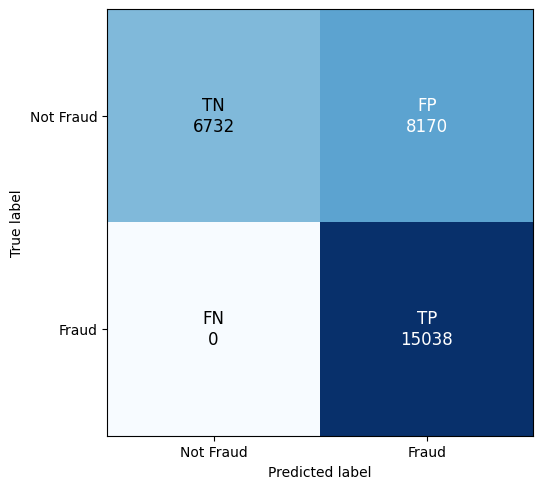

In [30]:
#Predict with the selected best parameter
y_pred=nbModel_grid.predict(X_test)

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

labels = np.array([['TN', 'FP'],
                   ['FN', 'TP']])

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues)

# 숫자 + 라벨 같이 출력
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if value > (cm.max() / 2.) else "black"
        ax.text(j, i, f"{labels[i, j]}\n{value}",
                ha='center', va='center', color=color, fontsize=12)


ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Not Fraud', 'Fraud'])
ax.set_yticklabels(['Not Fraud', 'Fraud'])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()




- TN (True Negative, 6,670)
실제로 사기가 아닌 거래( Not Fraud)를 모델이 사기가 아니라고 정확하게 예측한 경우.
→ 정상 거래를 잘 걸러낸 건수.

- FP (False Positive, 8,232)
실제로는 사기가 아닌 거래를 모델이 사기라고 잘못 예측한 경우.
→ 정상 거래인데 사기로 잘못 분류해서 발생하는 오탐.

- FN (False Negative, 0)
실제로는 사기인 거래를 모델이 정상이라고 잘못 예측한 경우.
→ 사기를 놓친 건수인데, 지금은 0건이라서 모델이 사기를 놓치지 않음.

- TP (True Positive, 15,038)
실제로 사기인 거래를 모델이 사기라고 정확하게 예측한 경우.
→ 사기를 정확히 잡아낸 건수.

장점: FN이 0이라서 사기를 전혀 놓치지 않음 → 재현율(Recall) 100%.

단점: FP가 8,232로 매우 높음 → 정상 거래도 사기라고 오판이 많아, 정밀도(Precision)가 낮을 수 있음.

해석: 모델이 사기 탐지에 매우 민감하게 설정되어 있어, 안전을 위해 모든 의심 거래를 잡지만, 그 과정에서 정상 거래도 많이 걸러버리는 패턴.

In [31]:
#Classification metrics
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.45      0.62     14902
       Fraud       0.65      1.00      0.79     15038

    accuracy                           0.73     29940
   macro avg       0.82      0.73      0.70     29940
weighted avg       0.82      0.73      0.70     29940



## 결론
- 모델의 평균적인 성능 : F1-score 기준 약 70%
- 사기를 놓치지 않는 대신, 정상 거래 어탐이 많아서 평균 성능이 완벽하지 않음

In [38]:
import joblib
import os

# 결과 디렉토리 생성
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/metrics/xai', exist_ok=True)

# 최적화된 Naive Bayes 모델 저장
joblib.dump(nbModel_grid.best_estimator_, '../results/models/naive_bayes_model.pkl')
joblib.dump(scaler, '../results/models/scaler.pkl')
joblib.dump(tokenizer_org, '../results/models/tokenizer_org.pkl')
joblib.dump(tokenizer_dest, '../results/models/tokenizer_dest.pkl')
joblib.dump(list(X_train.columns), '../results/models/feature_names.pkl')

print("모델과 전처리 객체들이 성공적으로 저장되었습니다.")

모델과 전처리 객체들이 성공적으로 저장되었습니다.


In [40]:
# 최종 모델 성능 요약
print("=== 최종 모델 성능 요약 ===")
print(f"모델: GaussianNB (var_smoothing={nbModel_grid.best_params_['var_smoothing']:.2e})")
print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
print(f"재현율: {metrics.recall_score(y_test, y_pred):.4f}")
print(f"정밀도: {metrics.precision_score(y_test, y_pred):.4f}")
print(f"F1-score: {metrics.f1_score(y_test, y_pred):.4f}")

print("\n=== 비즈니스 관점 평가 ===")
print("장점: 사기를 전혀 놓치지 않음 (재현율 100%)")
print("단점: 정상 거래를 사기로 오판하는 경우가 많음")
print("활용: 1차 필터링으로 사용, 2차 검증 필요")

=== 최종 모델 성능 요약 ===
모델: GaussianNB (var_smoothing=6.58e-09)
정확도: 0.7271
재현율: 1.0000
정밀도: 0.6480
F1-score: 0.7864

=== 비즈니스 관점 평가 ===
장점: 사기를 전혀 놓치지 않음 (재현율 100%)
단점: 정상 거래를 사기로 오판하는 경우가 많음
활용: 1차 필터링으로 사용, 2차 검증 필요


## 특성 중요도 및 모델 해석 분석

=== 특성 중요도 Top 15 ===
           feature  importance
15   customers_org    0.356948
16  customers_dest    0.305146
6        orig_diff    0.116591
3   newbalanceOrig    0.074195
13   type__PAYMENT    0.050276
0             step    0.031625
14  type__TRANSFER    0.016319
4   oldbalanceDest    0.015765
2    oldbalanceOrg    0.010287
11  type__CASH_OUT    0.005938
5   newbalanceDest    0.005212
1           amount    0.005109
10   type__CASH_IN    0.004695
12     type__DEBIT    0.000587
8            surge    0.000565


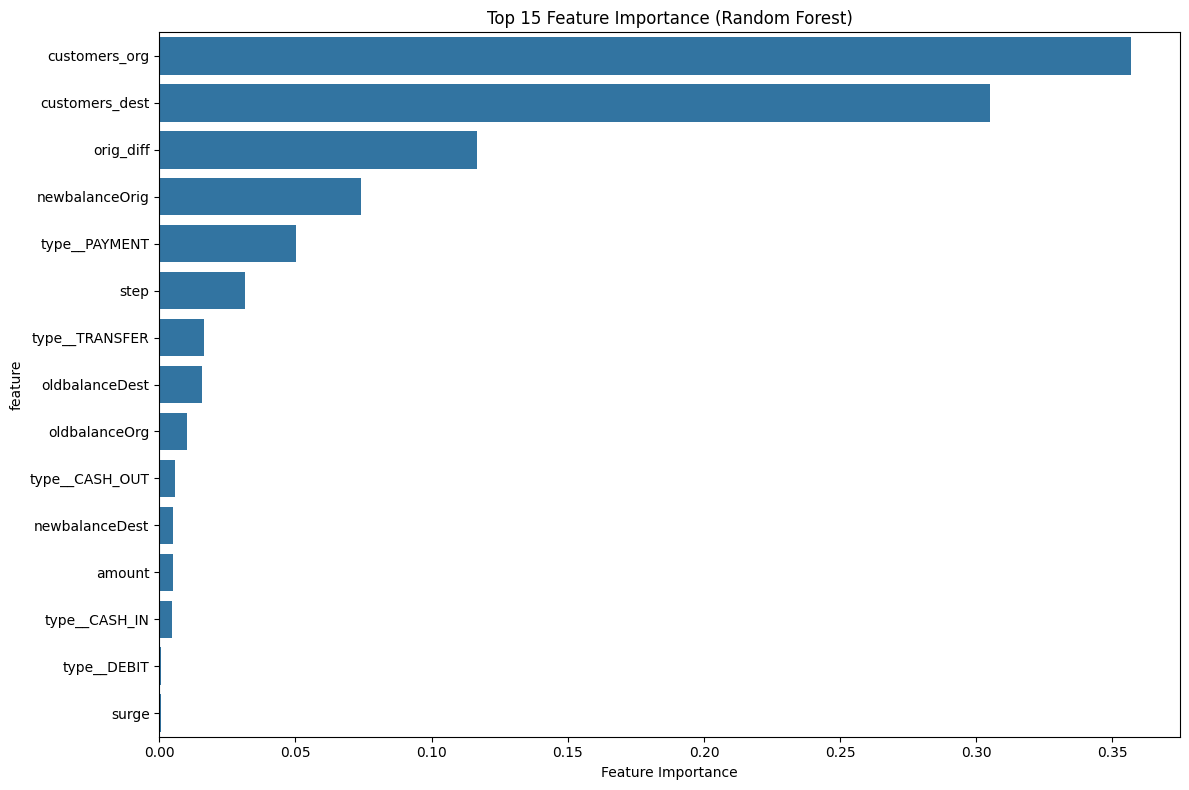

In [41]:
# 랜덤 포레스트로 특성 중요도 확인 (Naive Bayes는 특성 중요도를 직접 제공하지 않음)
rf_for_importance = RandomForestClassifier(n_estimators=100, random_state=123)
rf_for_importance.fit(X_train, y_train)

# 특성 중요도 데이터프레임 생성
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_for_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("=== 특성 중요도 Top 15 ===")
print(feature_importance.head(15))

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

## Feature engineering¶

## Feature engineering¶

## Feature engineering¶

## Feature engineering¶

## Feature engineering¶